Ensemble Methods for `clean_business_df` and `clean_economy_df`
- Bagging and Pasting
- Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
business_df = pd.read_csv('../../data/clean/clean_business_df.csv')
economy_df = pd.read_csv('../../data/clean/clean_economy_df.csv')

In [3]:
business_df.head()

,flight_date,airline_name,flight_code,departure_time,departure_city,arrival_time,arrival_city,flight_duration,stops,price,departure_time_group,arrival_time_group
0,2022-02-11,Air India,AI-868,18:00,Delhi,20:00,Mumbai,120,0,25612,Evening,Evening
1,2022-02-11,Air India,AI-624,19:00,Delhi,21:15,Mumbai,135,0,25612,Evening,Night
2,2022-02-11,Air India,AI-531,20:00,Delhi,20:45,Mumbai,1485,1,42220,Evening,Evening
3,2022-02-11,Air India,AI-839,21:25,Delhi,23:55,Mumbai,1590,1,44450,Night,Night
4,2022-02-11,Air India,AI-544,17:15,Delhi,23:55,Mumbai,400,1,46690,Afternoon,Night


In [4]:
economy_df.head()

,flight_date,airline_name,flight_code,departure_time,departure_city,arrival_time,arrival_city,flight_duration,stops,price,departure_time_group,arrival_time_group
0,2022-02-11,SpiceJet,SG-8709,18:55,Delhi,21:05,Mumbai,130,0,5953,Evening,Night
1,2022-02-11,SpiceJet,SG-8157,06:20,Delhi,08:40,Mumbai,140,0,5953,Morning,Morning
2,2022-02-11,Air Asia,I5-764,04:25,Delhi,06:35,Mumbai,130,0,5956,Early Morning,Morning
3,2022-02-11,Vistara,UK-995,10:20,Delhi,12:35,Mumbai,135,0,5955,Morning,Afternoon
4,2022-02-11,Vistara,UK-963,08:50,Delhi,11:10,Mumbai,140,0,5955,Morning,Morning


### 1. Data Preprocessing
- Convert 'flight_date' to datetime to extract relevant time features
- Encode categorical features
- Define Features (X) and Target (y)
- Split Data into Training and Testing sets

In [5]:
print(business_df.dtypes)

flight_date             object
airline_name            object
flight_code             object
departure_time          object
departure_city          object
arrival_time            object
arrival_city            object
flight_duration          int64
stops                    int64
price                    int64
departure_time_group    object
arrival_time_group      object
dtype: object


In [6]:
print(economy_df.dtypes)

flight_date             object
airline_name            object
flight_code             object
departure_time          object
departure_city          object
arrival_time            object
arrival_city            object
flight_duration          int64
stops                    int64
price                    int64
departure_time_group    object
arrival_time_group      object
dtype: object


1.1 - Convert 'flight_date' to datetime and extract relevant time features

In [7]:
# business
business_df['flight_date'] = pd.to_datetime(business_df['flight_date'])
business_df['departure_hour'] = business_df['departure_time'].apply(lambda x: int(x.split(':')[0]))
business_df['arrival_hour'] = business_df['arrival_time'].apply(lambda x: int(x.split(':')[0]))

In [8]:
# economy
economy_df['flight_date'] = pd.to_datetime(economy_df['flight_date'])
economy_df['departure_hour'] = economy_df['departure_time'].apply(lambda x: int(x.split(':')[0]))
economy_df['arrival_hour'] = economy_df['arrival_time'].apply(lambda x: int(x.split(':')[0]))

1.2 - Encode categorical features

In [9]:
def encode_categorical_features(df, encoding_method='label'):
    """
    This function encodes the categorical features in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the dataset
    - encoding_method: 'label' or 'onehot'. 'label' for LabelEncoding, 'onehot' for OneHotEncoding
    
    Returns:
    - df_encoded: pandas DataFrame with categorical features encoded
    """
    # identify categorical columns (exclude 'price' and date cols)
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # drop flight_date - should not be encoded
    if 'flight_date' in categorical_columns:
        categorical_columns.remove('flight_date')
    
    # initialize encoders
    if encoding_method == 'label':
        encoder = LabelEncoder()
        for col in categorical_columns:
            df[col] = encoder.fit_transform(df[col])
    elif encoding_method == 'onehot':
        # apply one-hot encoding
        df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
        return df_encoded
    else:
        raise ValueError("encoding_method must be 'label' or 'onehot'")
    
    return df

In [10]:
# encode business_df
business_encoded = encode_categorical_features(business_df, encoding_method='label')
# business_encoded.head()

In [11]:
# encode economy_df
economy_encoded = encode_categorical_features(economy_df, encoding_method='label')
# economy_encoded.head()

1.3 - Define Features and Target

In [12]:
# business
X_business = business_encoded[['airline_name', 'flight_duration', 'stops', 'departure_hour', 'arrival_hour', 
        'departure_city', 'arrival_city', 'departure_time_group', 'arrival_time_group']]
y_business = business_encoded['price']

In [13]:
# economy
X_economy = economy_encoded[['airline_name', 'flight_duration', 'stops', 'departure_hour', 'arrival_hour', 
        'departure_city', 'arrival_city', 'departure_time_group', 'arrival_time_group']]
y_economy = economy_encoded['price']

1.4. Split Data into Training and Testing Sets

In [14]:
# business
X_business_train, X_business_test, y_business_train, y_business_test = train_test_split(X_business, y_business, test_size=0.3, random_state=42)

In [15]:
# economy
X_economy_train, X_economy_test, y_economy_train, y_economy_test = train_test_split(X_economy, y_economy, test_size=0.3, random_state=42)


## Bagging and Pasting for 'price'

Business Class

In [16]:
# init  base learner (DecisionTreeRegressor)
base_model = DecisionTreeRegressor(random_state=42)

# init Bagging Regressor with bootstrap=False to simulate pasting
pasting_model = BaggingRegressor(base_model, n_estimators=100, bootstrap=False, max_samples=1.0, random_state=42)

# init Bagging Regressor with base model
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# train the model
bagging_model.fit(X_business_train, y_business_train)

# make predictions
y_pred = bagging_model.predict(X_business_test)

# train the model
pasting_model.fit(X_business_train, y_business_train)

# make predictions
y_pred_pasting = pasting_model.predict(X_business_test)

# evaluate
print("Bagging Regressor Evaluation for Business Class:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_business_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_business_test, y_pred))
print("R-squared (R2) Score:", r2_score(y_business_test, y_pred))

print("\nSimulated Pasting Regressor Evaluation for Business Class:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_business_test, y_pred_pasting))
print("Mean Squared Error (MSE):", mean_squared_error(y_business_test, y_pred_pasting))
print("R-squared (R2) Score:", r2_score(y_business_test, y_pred_pasting))

Bagging Regressor Evaluation for Business Class:
Mean Absolute Error (MAE): 2369.7947005004726
Mean Squared Error (MSE): 20358476.153942216
R-squared (R2) Score: 0.879825451279421

Simulated Pasting Regressor Evaluation for Business Class:
Mean Absolute Error (MAE): 2361.594853853363
Mean Squared Error (MSE): 20818515.053108282
R-squared (R2) Score: 0.8771098763668808


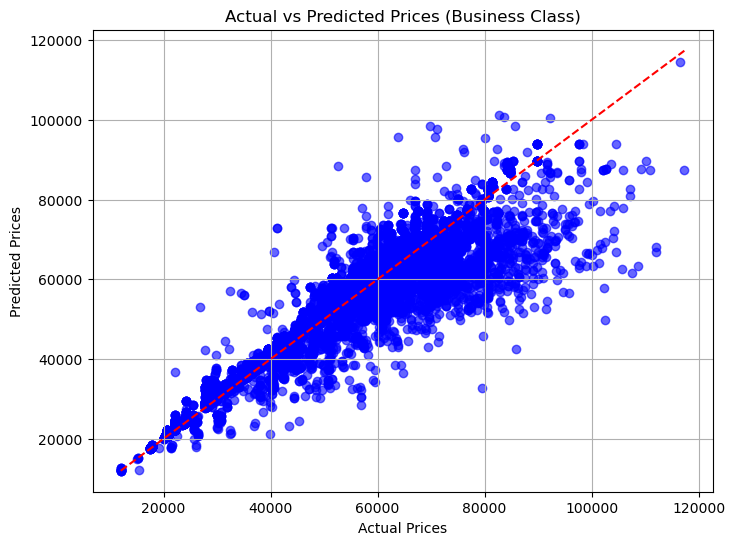

In [17]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_business_test, y_pred_pasting, color='blue', alpha=0.6)
plt.plot([min(y_business_test), max(y_business_test)], [min(y_business_test), max(y_business_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Prices (Business Class)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True)
plt.show()

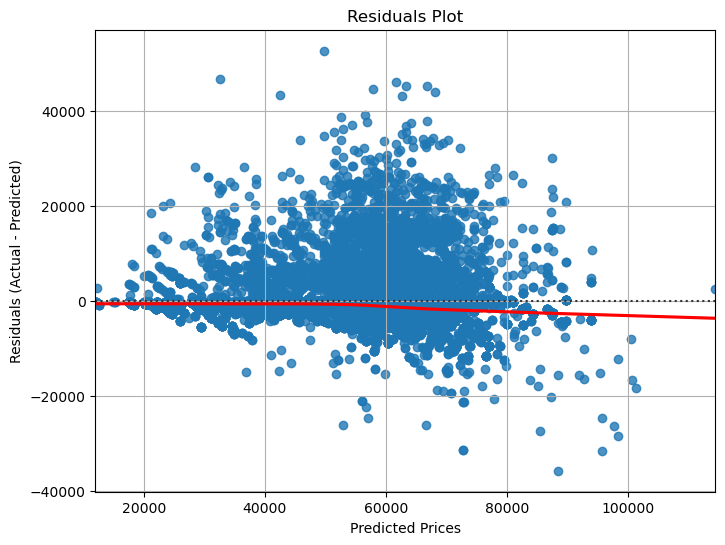

In [18]:
# Residual Plot
residuals = y_business_test - y_pred_pasting
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred_pasting, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title("Residuals Plot")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

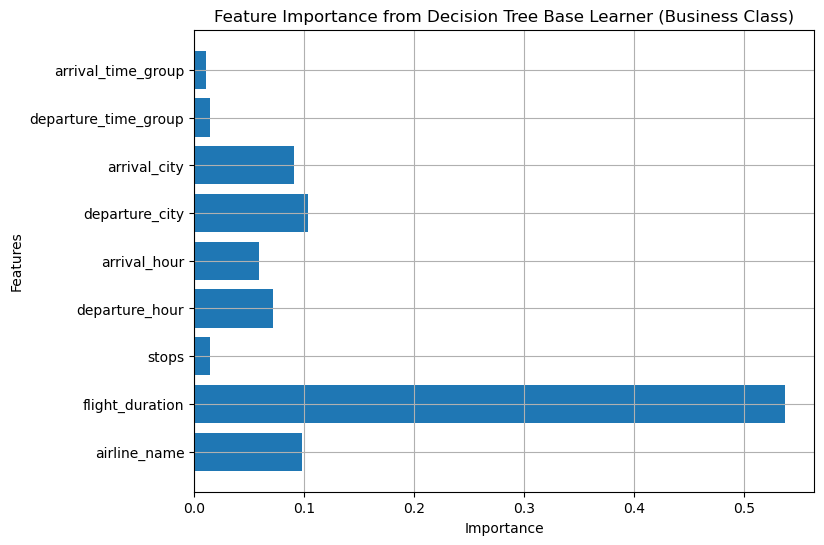

In [19]:
# Feature Importance Plot
importances = pasting_model.estimators_[0].feature_importances_
features = X_business.columns

plt.figure(figsize=(8, 6))
plt.barh(features, importances)
plt.title("Feature Importance from Decision Tree Base Learner (Business Class)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(True)
plt.show()

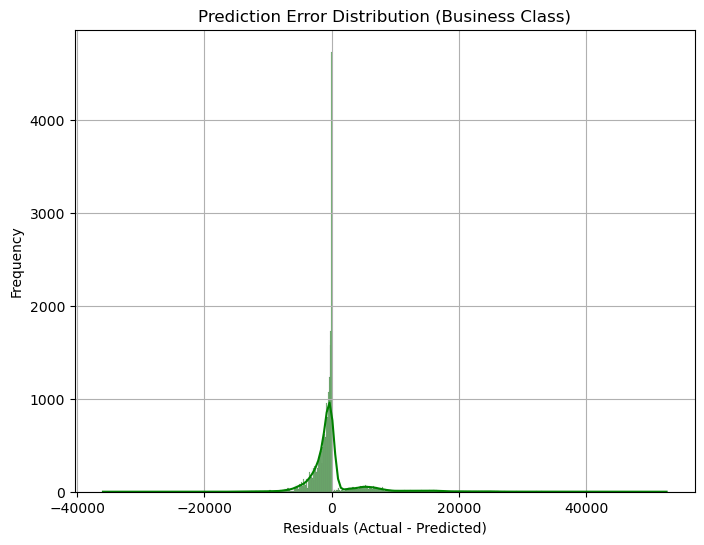

In [20]:
# 4. Prediction Error Distribution (Histogram of Residuals)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green')
plt.title("Prediction Error Distribution (Business Class)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Economy Class

In [21]:
# init base learner
base_model = DecisionTreeRegressor(random_state=42)

# init Bagging Regressor with bootstrap=False to simulate pasting
pasting_model = BaggingRegressor(base_model, n_estimators=100, bootstrap=False, max_samples=1.0, random_state=42)

# init Bagging Regressor with the base model
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# train the model
bagging_model.fit(X_economy_train, y_economy_train)

# make predictions
y_pred = bagging_model.predict(X_economy_test)

# train the model
pasting_model.fit(X_economy_train, y_economy_train)

# make predictions
y_pred_pasting = pasting_model.predict(X_economy_test)

# evaluate the model
print("Bagging Regressor Evaluation for Economy Class:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_economy_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_economy_test, y_pred))
print("R-squared (R2) Score:", r2_score(y_economy_test, y_pred))

print("\nSimulated Pasting Regressor Evaluation for Economy Class:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_economy_test, y_pred_pasting))
print("Mean Squared Error (MSE):", mean_squared_error(y_economy_test, y_pred_pasting))
print("R-squared (R2) Score:", r2_score(y_economy_test, y_pred_pasting))

Bagging Regressor Evaluation for Economy Class:
Mean Absolute Error (MAE): 2026.900643406834
Mean Squared Error (MSE): 8456962.349345174
R-squared (R2) Score: 0.39797516139426925

Simulated Pasting Regressor Evaluation for Economy Class:
Mean Absolute Error (MAE): 2021.5671102823999
Mean Squared Error (MSE): 8579548.549739618
R-squared (R2) Score: 0.3892486311746486


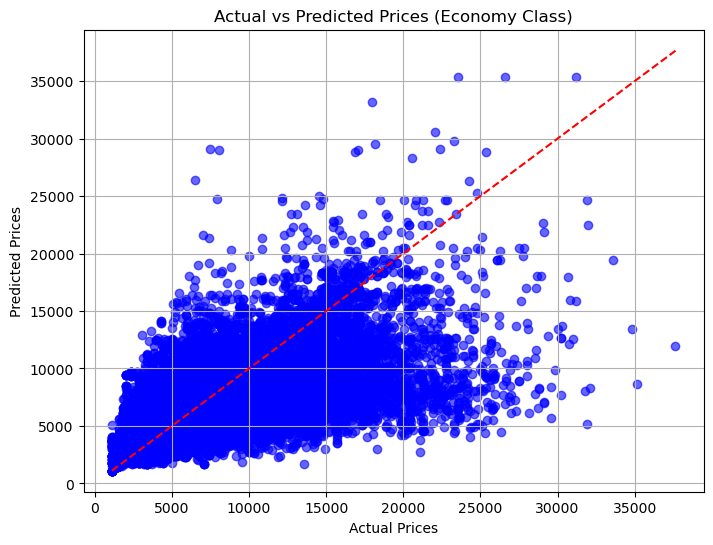

In [22]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_economy_test, y_pred_pasting, color='blue', alpha=0.6)
plt.plot([min(y_economy_test), max(y_economy_test)], [min(y_economy_test), max(y_economy_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Prices (Economy Class)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True)
plt.show()

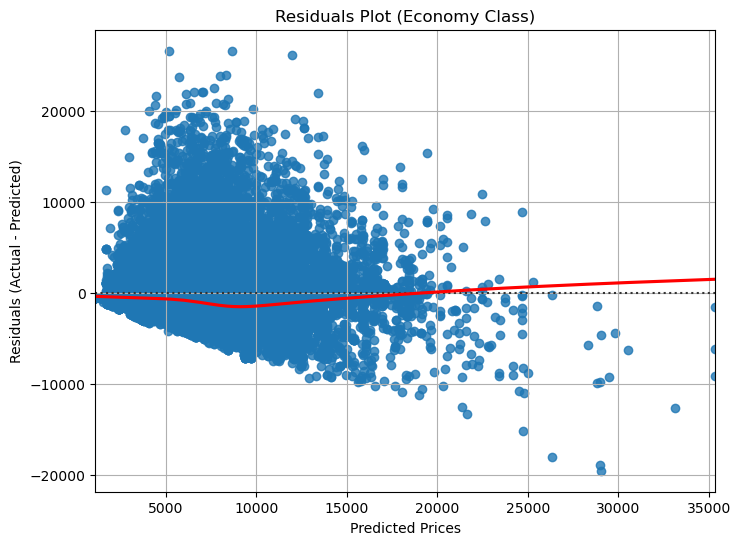

In [23]:
# Residual Plot
residuals = y_economy_test - y_pred_pasting
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred_pasting, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title("Residuals Plot (Economy Class)")
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

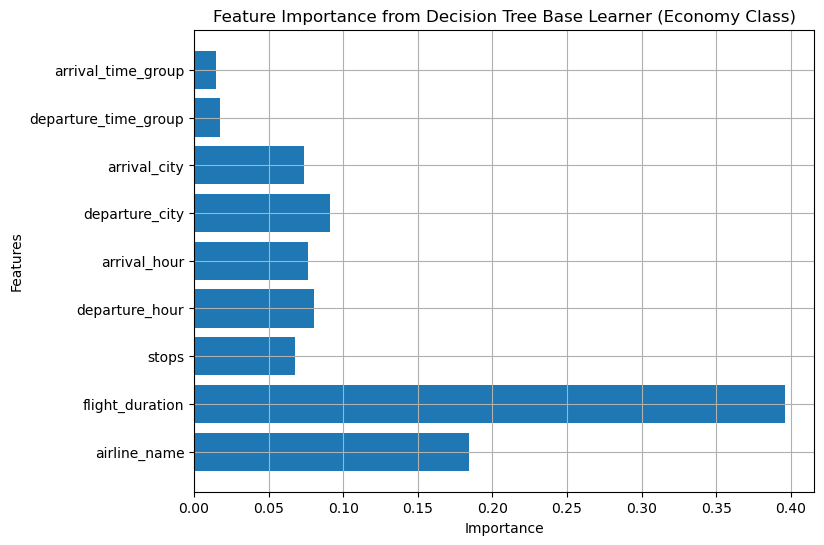

In [24]:
# Feature Importance Plot
importances = pasting_model.estimators_[0].feature_importances_
features = X_economy.columns

plt.figure(figsize=(8, 6))
plt.barh(features, importances)
plt.title("Feature Importance from Decision Tree Base Learner (Economy Class)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(True)
plt.show()

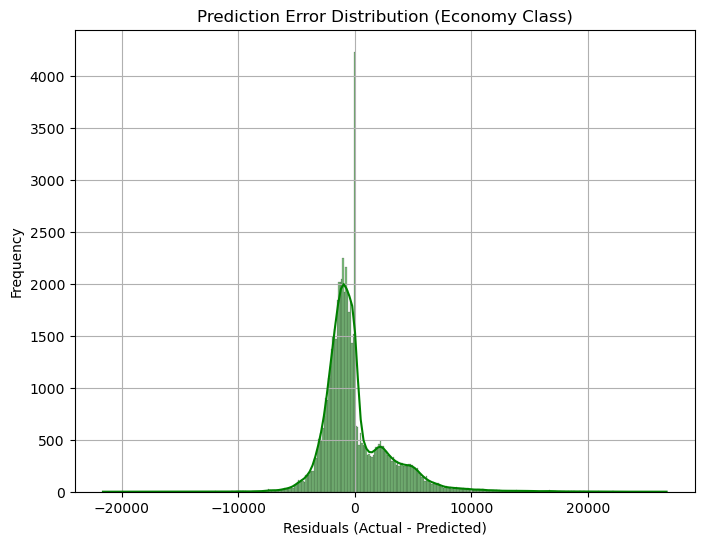

In [25]:
# Prediction Error Distribution (Histogram of Residuals)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green')
plt.title("Prediction Error Distribution (Economy Class)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()